# Check lfp-derived spikes

**Highlights**:

**Observation**:

- Except for a very few neurons, waveform plots are currently too noisy to see spikes:
    - hypothesis: this could be due to the small sample size (13 spikes max for 4 secs)
        - action: we should increase the simulation duration

**Questions**: 

**Notes**:


## Setup

[TODO]
- pretty print the config with indents
- why are the waveforms incorrect?

In [1]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe
from spikeinterface.comparison import GroundTruthStudy
import shutil
import logging
import logging.config
pd.set_option('display.max_colwidth', None)

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_study'

os.chdir(PROJ_PATH)
from src.pipelines.simulation.dataeng.loading import load_campaign_params
from src.pipelines.simulation.sorting import ground_truth
from src.pipelines.simulation.dataeng import loading_raw_recording
from src.pipelines.simulation.preprocessing import preprocess
from src.nodes.simulation.dataeng.filtering import get_cell_spiking_above_thresh, get_cell_id_spiking_above_thresh, create_study_object, filter_microcircuit_cells
from src.nodes.utils import get_config
from src.nodes import viz
from src.nodes.waveforms import get_waveforms, plot_waveforms

# SETUP PARAMETERS
# the date of the simulation to run
SIMULATION_DATE = "2023_01_13"

# traces parameters
CHANNEL_ID = np.arange(64,80).tolist()   # plot traces from channels nearest to filtered neuron group
N_SAMPLE = 80000                         # plot x-max (number of samples)
MIN_MAX_AMPLITUDE = [-400, 150]          # plot y-max (voltage)

# select active neurons
MIN_SPIKE = 10

# plot params
PLOT_OPTIONS = "save_only"

# SETUP CONFIG
print("CONFIG:\n")
config = get_config(SIMULATION_DATE)
pp.pprint(config["dataset_conf"])
pp.pprint(config["param_conf"])


# SETUP LOGGING
with open("conf/logging.yml", "r", encoding="utf-8") as logging_conf:
    LOG_CONF = yaml.load(logging_conf, Loader=yaml.FullLoader)
logging.config.dictConfig(LOG_CONF)
logger = logging.getLogger(__name__)

CONFIG:

2023-01-23 12:03:25,805 - root - utils.py - get_config - INFO - Loaded config
{'dataeng': {'campaign': {'input': {'simulation_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/simulations/'},
                          'output': {'spike_file_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/spiketrains.pkl',
                                     'trace_file_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/traces.pkl',
                                     'unit_trace_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/cells/'}},
             'chunking': {'input': {'campaign_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/reyes4s',
                                    'weight_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/coeffsreyespuerta.h5'},
             

setup custom functions

In [12]:
# custom functions
def get_most_active_cell(SortingObject, cell_id:np.array):
    """Get the global id of the most active cell among the cell_gids

    Args:
        SortingObject (_type_): Spikeinterface Sorting object
        cell_gid (np.array): _description_

    Returns:
        _type_: global id of the most active cell
    """

    id_spike_dict = SortingObject.get_total_num_spikes()
    pyramidal_id_spike_dict = {key: id_spike_dict[key] for key in cell_id}
    return max(pyramidal_id_spike_dict, key=pyramidal_id_spike_dict.get)

def get_unit_waveform(trace, spike_time, sampling_freq:int, ms_before:int, ms_after:int):
    n_sample_before = ms_before * sampling_freq / 1000
    n_sample_after = ms_after * sampling_freq / 1000
    waveform = []
    for spike in spike_time:
        this_waveform = trace[int(spike - n_sample_before) : int(spike + n_sample_after)]
        waveform.append(this_waveform)
    return np.array(waveform).T

def plot_unit_and_probe_location(
    cell_gid:int, circuit, raw_traces, preprocessed_traces, groundtruthspike, waveform_path:str, n_sample:int=80000, channel_id:list=[80, 55, 56, 57, 95], min_max_amplitude:list=[-150, 150]
    ):

    # inspect the probe's contact channels' locations
    probe = raw_traces.get_probe()

    # setup plot
    fig = plt.figure(figsize=(10,30));

    # setup layout
    spec = fig.add_gridspec(len(CHANNEL_ID), 2);

    # plot the unit's location with respect to the probe
    ax = fig.add_subplot(spec[:, 0]);
    plot_probe(probe.to_2d(axes='xy'), ax=ax, with_channel_index=True);

    # get unit true location
    unit_true_loc = circuit.cells.get(cell_gid, properties=["x","y","z"])

    # plot the unit's estimated location from the "center of mass" method
    ax.plot(unit_true_loc.x, unit_true_loc.y, "r+", markersize=20);

    # localize the most active unit
    # create waveform extractor to localize unit 
    WaveformExtractor = si.extract_waveforms(
        preprocessed_traces, 
        groundtruthspike, 
        waveform_path,
        load_if_exists=True, 
        overwrite=False,
        ms_before=2, 
        ms_after=2., 
        max_spikes_per_unit=None
        )
    cell_loc = spost.compute_unit_locations(WaveformExtractor, method="center_of_mass", outputs="by_unit")
    cell_estimated_loc = cell_loc[cell_gid]


    # plot the unit's estimated location
    ax.plot(cell_estimated_loc[0], cell_estimated_loc[1], "r.", markersize=20);

    # report
    print("neuron's true location (red dot) and estimated location (red cross)")

    # get most active unit's spike train
    most_active_unit_spikes = groundtruthspike.get_unit_spike_train(unit_id = cell_gid)
    most_active_unit_spikes = most_active_unit_spikes[most_active_unit_spikes<N_SAMPLE]

    # plot unit spikes against nearby channels' traces
    for ix in range(len(CHANNEL_ID)):
        
        # setup axis
        ax = fig.add_subplot(spec[ix, 1]);
        
        # plot preprocessed trace
        trace = preprocessed_traces.get_traces()[:N_SAMPLE, CHANNEL_ID[ix]]

        # legend
        ax.plot(trace);
        ax.eventplot(most_active_unit_spikes, linelengths = 20, lineoffsets=MIN_MAX_AMPLITUDE[1]*0.9, colors="r");    
        ax.set_title(f"channel id {CHANNEL_ID[ix]}")
        ax.set_ylim(MIN_MAX_AMPLITUDE)
        ax.legend(["preprocessed trace", "spike"], loc='upper right', bbox_to_anchor=(0.5, 0.5))
    plt.tight_layout();

def plot_unit_waveform_by_channel_custom(cell_spike, preprocessed_traces, channel_id:list, min_max_amplitude:list, ms_before:int, ms_after:int, figsize:tuple):

    # plot waveforms
    fig = plt.figure(figsize=figsize);
    n_channels = len(channel_id)
    for ix in range(n_channels):
        ax = fig.add_subplot(n_channels,1,ix+1);
        trace = preprocessed_traces.get_traces()[:N_SAMPLE,channel_id[ix]];
        unit_waveform = get_unit_waveform(trace, cell_spike, sampling_freq=20000, ms_before=ms_before, ms_after=ms_after);
        ax.plot(unit_waveform);
        ax.set_title(f"channel {channel_id[ix]}")
        ax.set_ylim(min_max_amplitude)
    plt.tight_layout()
    return fig
    
def plot_unit_waveform_by_channel_with_SI(preprocessed_traces, sorting_object, waveform_path, unit_id, channel_id:list, min_max_amplitude:list, ms_before:int, ms_after:int, figsize:tuple):

    # create waveform extractor
    WaveformExtractor = si.extract_waveforms(
        preprocessed_traces, 
        sorting_object, 
        waveform_path,
        overwrite=True,
        ms_before=ms_before, 
        ms_after=ms_after, 
        max_spikes_per_unit=None
        )

    # get unit waveforms (n_spikes, n_sample, n_channels)
    wfs = WaveformExtractor.get_waveforms(unit_id);    
    fig = plt.figure(figsize=figsize);
    n_channels = len(channel_id)
    for ix in range(n_channels):
        ax = fig.add_subplot(n_channels,1,ix+1);
        ax.plot(wfs[:,:,channel_id[ix]].T);
        ax.set_title(f"channel {channel_id[ix]}")
        ax.set_ylim(min_max_amplitude)
    plt.tight_layout()
    return fig

def plot_waveform_for(cell_ids:list, true_spike:si.core.unitsselectionsorting, preprocessed_traces: si.preprocessing, **kwargs:dict):
    """Plot best waveform for a chosen set of cell_ids

    Args:
        cell_ids (list): Cell global identifiers (gids)
        GroundTruthSpike (_type_): _description_
    """
    # select cell ground truth spikes
    true_spike = true_spike.select_units(cell_ids)

    # select active cell spking
    true_spike = get_cell_spiking_above_thresh(true_spike, min_spike=MIN_SPIKE)
    print(len(true_spike.unit_ids))

    # bundle spike and trace data for study
    study_object = create_study_object(preprocessed_traces, true_spike)

    # extract waveforms
    logger.info("Computing waveform ...")
    waveform_extractor = viz.get_waveform_extractor_and_ground_truth(study_object, study_folder=STUDY_FOLDER)
    logger.info("Computing waveform done.")

    # plot
    viz.plot_neuron_best_waveform(preprocessed_traces, true_spike, waveform_extractor, study_folder=STUDY_FOLDER, **kwargs)

def get_waveform_extractor_and_ground_truth(rec0, gt_sorting0, study_folder:str, min_spike:int, ms_before:int, ms_after:int):
    """Compute waveform and return their Extractor object

    Args:
        rec0 (_type_): _description_
        gt_sorting0 (_type_): _description_
        study_folder (str): _description_
        min_spike (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """


    # remove units with less than 10 spikes
    gt_dict = gt_sorting0.get_total_num_spikes()
    rare_gids = list(dict((k, v) for k, v in gt_dict.items() if v <= min_spike).keys())
    gt_sorting0 = gt_sorting0.remove_units(rare_gids)
    print("report gids with less than 10 spikes:", rare_gids[:5])
    print("report curated units: ", gt_sorting0)

    # create study object
    gt_dict = {
        'rec0': (rec0, gt_sorting0),
    }

    # overwrite existing data
    shutil.rmtree(study_folder, ignore_errors = True)
    study = GroundTruthStudy.create(study_folder, gt_dict)

    # get waveforms
    study.compute_waveforms(rec0, ms_before = ms_before, ms_after = ms_after)
    waveform_extractor = study.get_waveform_extractor(rec0)
    GroundTruth = study.get_ground_truth(rec0)
    return {
        "waveform_extractor" : waveform_extractor, 
        "GroundTruth" : GroundTruth
        }

setup cell filtering queries

In [3]:
# load campaign parameters
simulation = load_campaign_params(config["dataset_conf"], config["param_conf"])

# get microcircuit's 30K cells
microcircuit_cells = filter_microcircuit_cells(simulation)
print("Microcircuit cells (count): ", len(microcircuit_cells["gid"]))

# get Spikeinterface's Sorting object for near-probe cells
# TODO: add argument to select near-probe cells or not
output = ground_truth.run(simulation, config["dataset_conf"], config["param_conf"])
SortingObject = output["ground_truth_sorting_object"]
print("- Near-probe cell (count): ", SortingObject.get_num_units())

# get cell properties
cell_location = simulation["circuit"].cells.get(SortingObject.unit_ids, properties=['x','y','z'])

# get active cells (spike count above MIN_SPIKE)
active_cell_gids = get_cell_id_spiking_above_thresh(SortingObject, min_spike=MIN_SPIKE)
print("- near-probe active cell (count): ", len(active_cell_gids))

# get cell morph_class
cell_morph_class = simulation["circuit"].cells.get(SortingObject.unit_ids, properties=['morph_class'])
print("- near-probe morph classes (count): ", np.unique(cell_morph_class))

# get pyramidal cells
pyramidal_gids = cell_morph_class[cell_morph_class["morph_class"] == "PYR"].index.values
print("- near-probe pyramidal cell (count): ", len(pyramidal_gids))

# get active pyramidal cells
active_pyramidal_gids = list(set(pyramidal_gids) & set(active_cell_gids))
print("- near-probe active pyramidal cell (count): ", len(active_pyramidal_gids))

# get interneuron cells
interneuron_gids = cell_morph_class[cell_morph_class["morph_class"] == "INT"].index.values
print("- near-probe interneuron cell (count): ", len(interneuron_gids))

# get active interneuron cells
active_interneuron_gids = list(set(interneuron_gids) & set(active_cell_gids))
print("- near-probe active interneuron cell (count): ", len(active_interneuron_gids))

# get the most active pyramidal cell and its spike count
most_active_pyr_gid = get_most_active_cell(SortingObject, cell_id=pyramidal_gids)
most_active_pyr_spike_count = SortingObject.get_total_num_spikes()[most_active_pyr_gid]
print("- near-probe most active pyramidal cell id: ", most_active_pyr_gid)
print("- near-probe most active pyramidal cell spike (count): ", most_active_pyr_spike_count)

2023-01-23 12:03:36,126 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
Microcircuit cells (count):  30190
- Near-probe cell (count):  1221
- near-probe active cell (count):  750
- near-probe morph classes (count):  ['INT' 'PYR']
- near-probe pyramidal cell (count):  1090
- near-probe active pyramidal cell (count):  660
- near-probe interneuron cell (count):  131
- near-probe active interneuron cell (count):  90
- near-probe most active pyramidal cell id:  3754013
- near-probe most active pyramidal cell spike (count):  106


## 3D locate

In [4]:
# get the probe wired to the traces
preprocessed_traces = preprocess.run(config["dataset_conf"], config["param_conf"])
probe = preprocessed_traces.get_probe()

# locate near-probe cells
near_probe_cell = simulation["circuit"].cells.get(SortingObject.unit_ids, properties=[ 
    'x','y','z'])

# locate near-probe most active pyramidal cell
most_active_pyr_location = near_probe_cell[near_probe_cell.index==most_active_pyr_gid]

2023-01-23 12:03:47,046 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None


legend: 8-shank 128 contact channel probe (green), microcircuit (blue dots) and near-probe cells (red dots), most active pyramidal cell (yellow bubble)


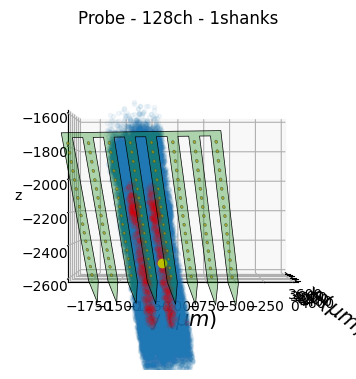

In [5]:
# plot probe, microcircuit and near-probe cells
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(143, projection='3d')
ax.view_init(0, 0)

# plot the probe wired to the traces
plot_probe(probe, ax=ax);
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

# plot microcircuit cells
plt.plot(microcircuit_cells["soma_location"].x, microcircuit_cells["soma_location"].y, microcircuit_cells["soma_location"].z, ".", alpha=0.05);

# plot near-probe cells
plt.plot(near_probe_cell.x, near_probe_cell.y, near_probe_cell.z, "r.", alpha=0.05);

# plot near-probe most active pyramidal cell
plt.plot(most_active_pyr_location.x, most_active_pyr_location.y, most_active_pyr_location.z, "yo");
print("legend: 8-shank 128 contact channel probe (green), microcircuit (blue dots) and near-probe cells (red dots), most active pyramidal cell (yellow bubble)")

### plot nearby channel traces

In [6]:
# get raw traces
simulated_traces = loading_raw_recording.load(config["dataset_conf"], config["param_conf"])

2023-01-23 12:04:23,488 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/


neuron's true location (red dot) and estimated location (red cross)


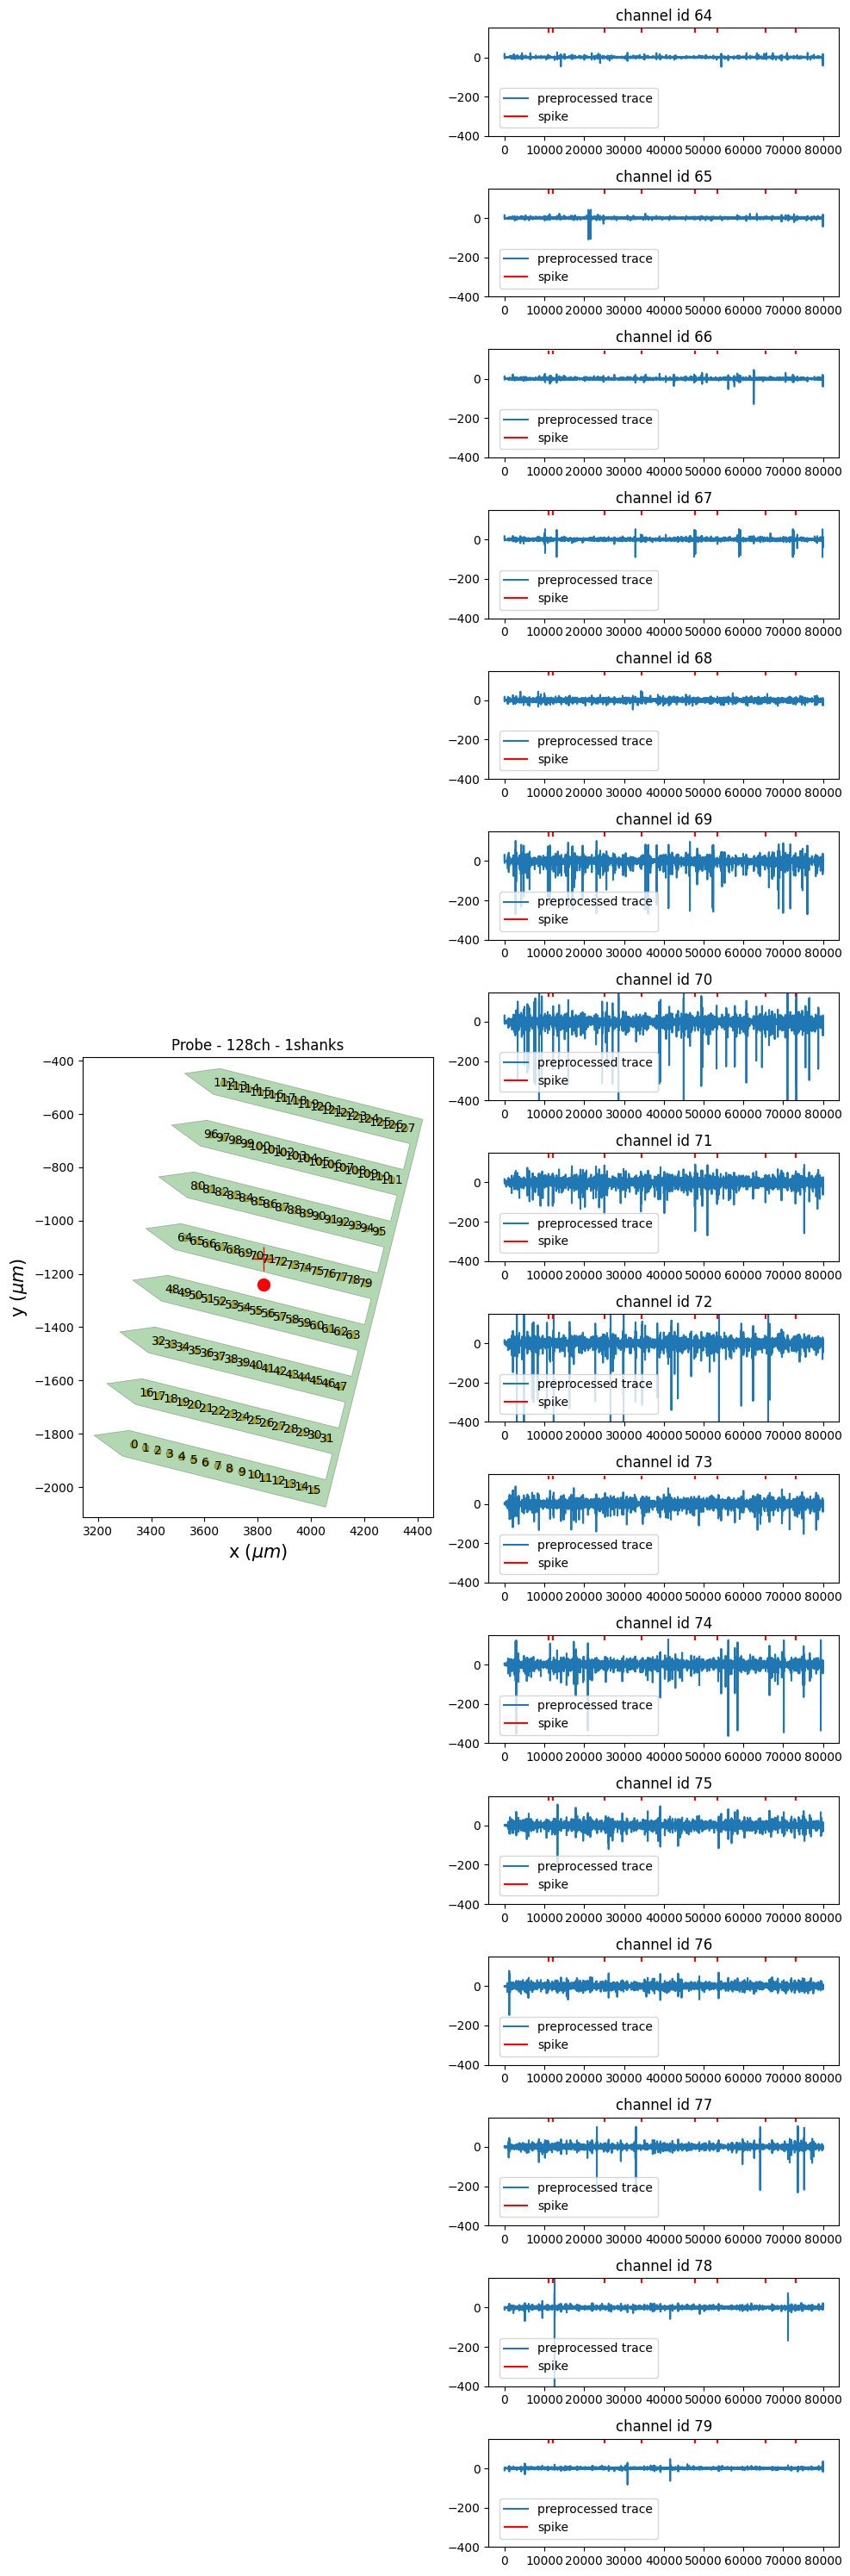

In [7]:
# plot with channel traces
plot_unit_and_probe_location(
    cell_gid=most_active_pyr_gid, 
    circuit=simulation["circuit"], 
    raw_traces=simulated_traces, 
    preprocessed_traces=preprocessed_traces, 
    groundtruthspike=SortingObject, 
    waveform_path=config["dataset_conf"]["sorting"]["simulation"]["waveform_path"]["output"],
    n_sample=N_SAMPLE, 
    channel_id=CHANNEL_ID, 
    min_max_amplitude=MIN_MAX_AMPLITUDE
    )

## Check spike waveforms

###  check method

#### Method 1

[TODO]:
- The waveforms seem incorrect
    - obs:
        - Action potentials should be centered but occur later
        - extracted waveforms from SpikeInterface are always 80 steps x-axis despite ms_before, why?
    - hypothesis: 
        - the spikes are associated with the wrong trace files
        - the cell location is wrong


In [8]:
print("One trace timestep (sample) is:", (1/20000)*1000, "ms")

One trace timestep (sample) is: 0.05 ms


In [9]:
# report object type
print("Input object types:")
print(type(SortingObject))
print(type(preprocessed_traces))

Input object types:
<class 'spikeinterface.core.npzfolder.NpzFolderSorting'>
<class 'spikeinterface.preprocessing.common_reference.CommonReferenceRecording'>


In [10]:
# set waveform parameters
MS_BEFORE = 3
MS_AFTER = 4
MIN_MAX_AMPLITUDE = [-200, 200]

# compute waveforms for selected neurons (a bit slow)
out = get_waveform_extractor_and_ground_truth(
    preprocessed_traces, 
    SortingObject, 
    study_folder=config["dataset_conf"]["sorting"]["simulation"]["study"]["output"], 
    min_spike=MIN_SPIKE, 
    ms_before=MS_BEFORE, 
    ms_after=MS_AFTER
    )

report gids with less than 10 spikes: [10250, 20590, 47971, 48718, 49465]
report curated units:  UnitsSelectionSorting: 731 units - 1 segments - 20.0kHz
write_binary_recording with n_jobs = 1 and chunk_size = None


TODO:
- the two methods produce different results while they should not -> check why?

In [14]:
# plot
fig = plot_unit_waveform_by_channel_with_SI(
    preprocessed_traces, 
    SortingObject, 
    config["dataset_conf"]["sorting"]["simulation"]["waveform_path"]["output"], 
    most_active_pyr_gid, 
    channel_id=CHANNEL_ID, 
    min_max_amplitude=MIN_MAX_AMPLITUDE, 
    ms_before=MS_BEFORE, 
    ms_after=MS_AFTER,
    figsize=(2,30)
    )

AssertionError: 

cell (gid):  3754013
spike (count):  15
legend: spikes (color)


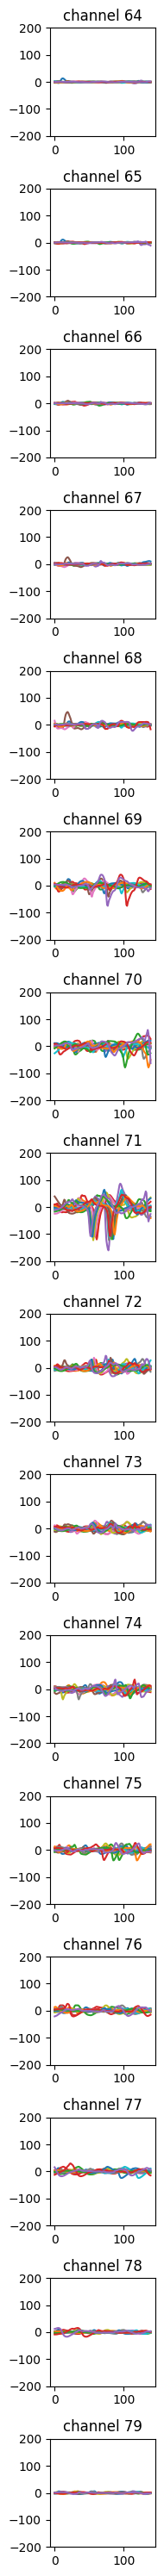

In [ ]:
# get most active unit's spikes
most_active_pyr_spikes = SortingObject.get_unit_spike_train(unit_id = most_active_pyr_gid)
most_active_pyr_spikes = most_active_pyr_spikes[most_active_pyr_spikes<N_SAMPLE]

# report 
print("cell (gid): ", most_active_pyr_gid)
print("spike (count): ", len(most_active_pyr_spikes))
print("legend: spikes (color)")

# replicate plot with custom code to validate
fig = plot_unit_waveform_by_channel_custom(
    cell_spike = most_active_pyr_spikes, 
    preprocessed_traces=preprocessed_traces, 
    channel_id=CHANNEL_ID, 
    min_max_amplitude=MIN_MAX_AMPLITUDE, 
    ms_before=MS_BEFORE, 
    ms_after=MS_AFTER, 
    figsize=(2,30)
)

### check by cell type

We plotted waveforms for all active cells sorted by type

In [15]:
# report cell morphological types
cell_morph_class.morph_class.unique()

['PYR', 'INT']
Categories (2, object): ['INT', 'PYR']

#### Pyramidal cells

Spike waveform figures are saved in figures/pyramidal. You can use VSCODE `image viewer extension` to visualize them at once.   
note: images are not displayed but saved because, the notebook can't handle plotting hundreds of images.

[TODO]:
- add location to probe information

In [16]:
# create path and overwrite figures
shutil.rmtree("figures/pyramidal/")
os.makedirs("figures/pyramidal/")
os.chdir("figures/pyramidal/")

# compute and save plots
plot_waveform_for(active_pyramidal_gids, SortingObject, preprocessed_traces, plot_options=PLOT_OPTIONS)

# move back to project path
os.chdir("../../")

642
2023-01-23 12:12:45,688 - __main__ - 97458697.py - plot_waveform_for - INFO - Computing waveform ...
write_binary_recording with n_jobs = 1 and chunk_size = None
2023-01-23 12:14:26,836 - __main__ - 97458697.py - plot_waveform_for - INFO - Computing waveform done.
write_binary_recording with n_jobs = 1 and chunk_size = None


#### Interneurons

Spike waveform figures are saved in figures/interneurons.   

[TODO]:
- add location to probe information

In [15]:
# create path and overwrite figures
if os.path.isdir("figures/interneurons/"):
    shutil.rmtree("figures/interneurons/")
os.makedirs("figures/interneurons/")
os.chdir("figures/interneurons/")

# compute and save plots
plot_waveform_for(active_interneuron_gids, SortingObject, preprocessed_traces, plot_options=PLOT_OPTIONS)

# move back to project path
os.chdir("../../")

89
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None
